## Section 4: Bayesian Regression
TODO: Fixed effects model

TODO: Mixed effects model

TODO: Investigate why mu is estimated per row

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from datetime import datetime
from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

In [3]:
X = messages[['is_weekend','day_of_week','message_length','num_participants']].values
_, num_X = X.shape

# investigate why mu is estimated per row
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=100, shape=num_X)
        
    mu = pm.Deterministic('mu', var=tt.exp(tt.dot(X, beta)))
    
    #y_pred = pm.Poisson('y_pred', mu=mu)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.1 sec

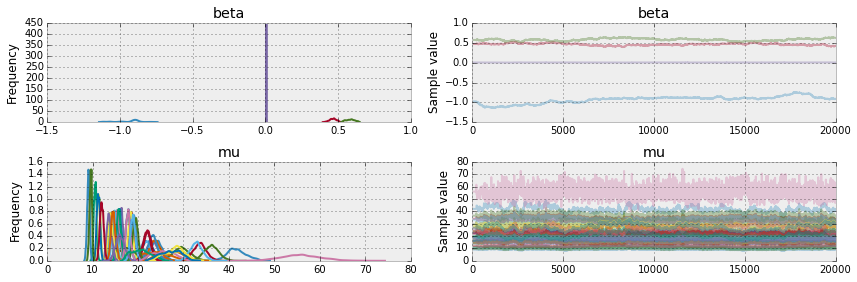

In [4]:
_ = pm.traceplot(trace)

TODO: Mixed effects model

In [6]:
message_length = messages['message_length'].values

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_participants)
    slope = pm.Normal('slope', mu=0, sd=100, shape=n_participants)
    
    mu = tt.exp(intercept[participants_idx] + slope[participants_idx]*message_length)
    
    y_pred = pm.Poisson('y_pred', mu=mu, shape=participants_idx.shape)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

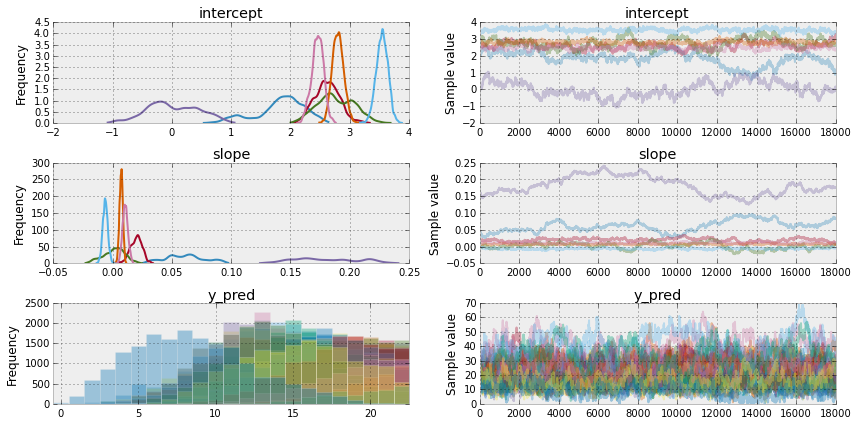

In [7]:
_ = pm.traceplot(trace[2000:])

In [1]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()